In [ ]:
import numpy as np
import cv2
import glob
import os
import matplotlib.pyplot as plt
import string
from mlxtend.plotting import plot_decision_regions
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.utils.multiclass import unique_labels
from sklearn import metrics
from sklearn.svm import SVC
dim = 100

In [ ]:
from imutils import paths
import cv2

In [ ]:
!unzip /content/drive/MyDrive/Tomato.zip -d MTP

Streaming output truncated to the last 5000 lines.
  inflating: MTP/dataset/train/Target_Spot/1 (1).JPG  
  inflating: MTP/dataset/train/Target_Spot/1 (10).JPG  
  inflating: MTP/dataset/train/Target_Spot/1 (100).JPG  
  inflating: MTP/dataset/train/Target_Spot/1 (1000).JPG  
  inflating: MTP/dataset/train/Target_Spot/1 (101).JPG  
  inflating: MTP/dataset/train/Target_Spot/1 (102).JPG  
  inflating: MTP/dataset/train/Target_Spot/1 (103).JPG  
  inflating: MTP/dataset/train/Target_Spot/1 (104).JPG  
  inflating: MTP/dataset/train/Target_Spot/1 (105).JPG  
  inflating: MTP/dataset/train/Target_Spot/1 (106).JPG  
  inflating: MTP/dataset/train/Target_Spot/1 (107).JPG  
  inflating: MTP/dataset/train/Target_Spot/1 (108).JPG  
  inflating: MTP/dataset/train/Target_Spot/1 (109).JPG  
  inflating: MTP/dataset/train/Target_Spot/1 (11).JPG  
  inflating: MTP/dataset/train/Target_Spot/1 (110).JPG  
  inflating: MTP/dataset/train/Target_Spot/1 (111).JPG  
  inflating: MTP/dataset/train/Target_Sp

In [ ]:
import os

# Define the paths for the train and test datasets
train_base_dir = '/content/MTP/dataset/train'
test_base_dir = '/content/MTP/dataset/val'

# List of class names to keep
class_names_to_keep = [
    "Late_blight", "Tomato_mosaic_virus", "healthy",
    "Septoria_leaf_spot", "Bacterial_spot", "Tomato_Yellow_Leaf_Curl_Virus"
]

# Create lists to store the file paths for train and test images
train_image_paths = []
test_image_paths = []

# Populate the train and test image paths based on the specified classes
for class_name in class_names_to_keep:
    train_image_paths.extend([os.path.join(train_base_dir, class_name, filename) for filename in os.listdir(os.path.join(train_base_dir, class_name))])
    test_image_paths.extend([os.path.join(test_base_dir, class_name, filename) for filename in os.listdir(os.path.join(test_base_dir, class_name))])


In [ ]:
import cv2

# Function to apply histogram equalization to an image
def apply_histogram_equalization(image_path):
    # Read the image
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)

    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply histogram equalization
    equalized = cv2.equalizeHist(gray)

    # Merge the equalized channel to the original image
    img[:, :, 0] = equalized

    return img

# Apply histogram equalization to train images
for image_path in train_image_paths:
    img = apply_histogram_equalization(image_path)
    # Save the equalized image back to the original path
    cv2.imwrite(image_path, img)

# Apply histogram equalization to test images
for image_path in test_image_paths:
    img = apply_histogram_equalization(image_path)
    # Save the equalized image back to the original path
    cv2.imwrite(image_path, img)


In [ ]:
import cv2
import os

# Function to apply histogram equalization to an image
def apply_histogram_equalization(image_path):
    # Read the image
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)

    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply histogram equalization
    equalized = cv2.equalizeHist(gray)

    # Merge the equalized channel to the original image
    img[:, :, 0] = equalized

    return img

# Directory to save equalized train images
equalized_train_dir = '/content/MTP/dataset/equalized_images/train'

# Directory to save equalized test images
equalized_test_dir = '/content/MTP/dataset/equalized_images/test'

# Create the directories if they don't exist
os.makedirs(equalized_train_dir, exist_ok=True)
os.makedirs(equalized_test_dir, exist_ok=True)

# Apply histogram equalization to train images and save
for image_path in train_image_paths:
    img = apply_histogram_equalization(image_path)

    # Get the relative path within the class directory
    relative_path = os.path.relpath(image_path, train_base_dir)

    # Construct the path for the equalized image
    equalized_path = os.path.join(equalized_train_dir, relative_path)

    # Create directories if they don't exist
    os.makedirs(os.path.dirname(equalized_path), exist_ok=True)

    # Save the equalized image
    cv2.imwrite(equalized_path, img)

# Apply histogram equalization to test images and save
for image_path in test_image_paths:
    img = apply_histogram_equalization(image_path)

    # Get the relative path within the class directory
    relative_path = os.path.relpath(image_path, test_base_dir)

    # Construct the path for the equalized image
    equalized_path = os.path.join(equalized_test_dir, relative_path)

    # Create directories if they don't exist
    os.makedirs(os.path.dirname(equalized_path), exist_ok=True)

    # Save the equalized image
    cv2.imwrite(equalized_path, img)


In [ ]:
!pip install tensorflow


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image dimensions and batch size
image_height, image_width = 224, 224
batch_size = 32

# Define a function to load and preprocess the images, including labels
def load_and_preprocess_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [image_height, image_width])
    image = image / 255.0
    return image, label

# Create TensorFlow Datasets with labels
train_labels = [0 if "healthy" in path else 1 for path in train_image_paths]
test_labels = [0 if "healthy" in path else 1 for path in test_image_paths]

train_dataset = tf.data.Dataset.from_tensor_slices((train_image_paths, train_labels))
train_dataset = train_dataset.map(load_and_preprocess_image)
train_dataset = train_dataset.batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices((test_image_paths, test_labels))
test_dataset = test_dataset.map(load_and_preprocess_image)
test_dataset = test_dataset.batch(batch_size)

# Define and compile the CNN model as before

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.metrics import precision_score, f1_score

# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(image_height, image_width, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification, so using sigmoid activation
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model on the training dataset
model.fit(train_dataset, epochs=10)

# Save the model weights
model.save_weights('model_weights.h5')

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f'Test Accuracy: {test_accuracy}')

# Make predictions on the test dataset
predictions = model.predict(test_dataset)
binary_predictions = (predictions > 0.5).astype(int)

# Convert test_labels to a NumPy array
true_labels = np.array(test_labels).astype(int)

# Calculate precision and F1 score
precision = precision_score(true_labels, binary_predictions)
f1 = f1_score(true_labels, binary_predictions)

print(f'Precision: {precision}')
print(f'F1 Score: {f1}')


Epoch 1/10
188/188 [==============================] - 12s 51ms/step - loss: 4.9191 - accuracy: 0.9413
Epoch 2/10
188/188 [==============================] - 9s 48ms/step - loss: 1.0180 - accuracy: 0.9160
Epoch 3/10
188/188 [==============================] - 10s 50ms/step - loss: 0.8015 - accuracy: 0.7240
Epoch 4/10
188/188 [==============================] - 10s 56ms/step - loss: 0.6435 - accuracy: 0.8333
Epoch 5/10
188/188 [==============================] - 8s 45ms/step - loss: 0.6064 - accuracy: 0.8333
Epoch 6/10
188/188 [==============================] - 10s 55ms/step - loss: 0.5784 - accuracy: 0.8333
Epoch 7/10
188/188 [==============================] - 10s 52ms/step - loss: 0.5563 - accuracy: 0.8333
Epoch 8/10
188/188 [==============================] - 9s 46ms/step - loss: 0.5386 - accuracy: 0.8333
Epoch 9/10
188/188 [==============================] - 10s 54ms/step - loss: 0.5242 - accuracy: 0.8333
Epoch 10/10
19/19 [==============================] - 1s 54ms/step - loss: 0.5056 - ac

Epoch 1/10
188/188 [==============================] - 14s 60ms/step - loss: 3.4931 - accuracy: 0.9107 - val_loss: 19.3806 - val_accuracy: 0.8333
Epoch 2/10
188/188 [==============================] - 11s 57ms/step - loss: 1.7555 - accuracy: 0.8995 - val_loss: 2.4851 - val_accuracy: 0.8333
Epoch 3/10
188/188 [==============================] - 9s 50ms/step - loss: 0.7924 - accuracy: 0.6733 - val_loss: 2.1637 - val_accuracy: 0.8333
Epoch 4/10
188/188 [==============================] - 11s 59ms/step - loss: 0.7288 - accuracy: 0.8520 - val_loss: 1.3857 - val_accuracy: 0.8333
Epoch 5/10
188/188 [==============================] - 9s 47ms/step - loss: 0.5697 - accuracy: 0.8333 - val_loss: 0.4775 - val_accuracy: 0.8333
Epoch 6/10
188/188 [==============================] - 10s 55ms/step - loss: 0.4912 - accuracy: 0.8307 - val_loss: 1.8025 - val_accuracy: 0.8333
Epoch 7/10
188/188 [==============================] - 11s 58ms/step - loss: 0.7089 - accuracy: 0.8333 - val_loss: 0.6360 - val_accuracy: 

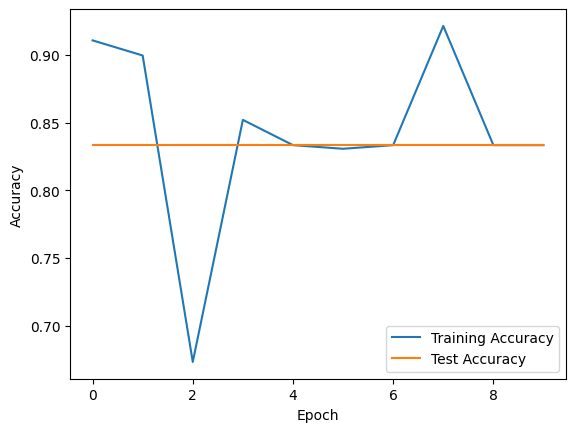

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.metrics import precision_score, f1_score

# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(image_height, image_width, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification, so using sigmoid activation
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model on the training dataset and get the history
history = model.fit(train_dataset, epochs=10, validation_data=test_dataset)

# Save the model weights
model.save_weights('model_weights.h5')

# Plot training and test accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
# Make predictions on the test dataset
predictions = model.predict(test_dataset)
binary_predictions = (predictions > 0.5).astype(int)

# Convert test_labels to a NumPy array
true_labels = np.array(test_labels).astype(int)

# Calculate precision and F1 score
precision = precision_score(true_labels, binary_predictions)
f1 = f1_score(true_labels, binary_predictions)

print(f'Precision: {precision}')
print(f'F1 Score: {f1}')


19/19 [==============================] - 1s 33ms/step
Precision: 0.8333333333333334
F1 Score: 0.9090909090909091


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.metrics import precision_score, f1_score

# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(image_height, image_width, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification, so using sigmoid activation
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model on the training dataset
model.fit(train_dataset, epochs=10)

# Save the model weights
model.save_weights('model_weights.h5')

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f'Test Accuracy: {test_accuracy}')

# Make predictions on the test dataset
predictions = model.predict(test_dataset)
binary_predictions = (predictions > 0.5).astype(int)

# Assuming your test labels are binary (0 or 1)
true_labels = test_labels.numpy().astype(int)

# Calculate precision and F1 score
precision = precision_score(true_labels, binary_predictions)
f1 = f1_score(true_labels, binary_predictions)

print(f'Precision: {precision}')
print(f'F1 Score: {f1}')


Epoch 1/10
188/188 [==============================] - 20s 61ms/step - loss: 4.4143 - accuracy: 0.9112
Epoch 2/10
188/188 [==============================] - 12s 64ms/step - loss: 0.8749 - accuracy: 0.8840
Epoch 3/10
188/188 [==============================] - 11s 57ms/step - loss: 0.8892 - accuracy: 0.6653
Epoch 4/10
188/188 [==============================] - 11s 59ms/step - loss: 0.6513 - accuracy: 0.8333
Epoch 5/10
188/188 [==============================] - 9s 50ms/step - loss: 0.6135 - accuracy: 0.8333
Epoch 6/10
188/188 [==============================] - 10s 54ms/step - loss: 0.5847 - accuracy: 0.8333
Epoch 7/10
188/188 [==============================] - 9s 48ms/step - loss: 0.5618 - accuracy: 0.8333
Epoch 8/10
188/188 [==============================] - 10s 54ms/step - loss: 0.5433 - accuracy: 0.8333
Epoch 9/10
188/188 [==============================] - 9s 50ms/step - loss: 0.5282 - accuracy: 0.8333
Epoch 10/10
19/19 [==============================] - 2s 85ms/step - loss: 0.5087 - ac

AttributeError: ignored

1/1 [==============================] - 0s 21ms/step


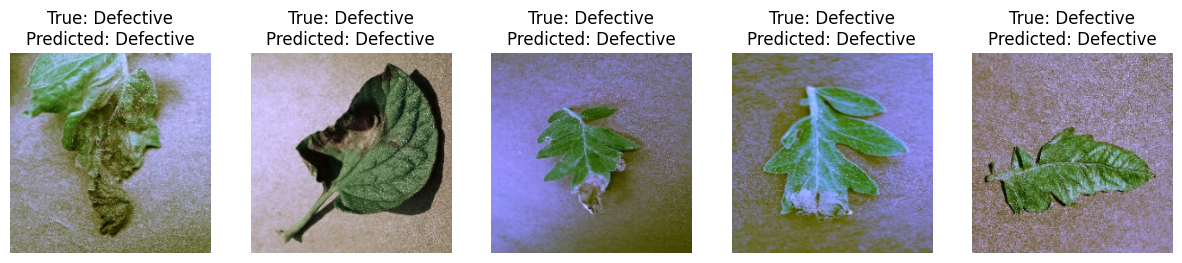

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming train_dataset and test_dataset are BatchDataset objects

# Function to get a batch of random images and labels
def get_random_batch(dataset, batch_size=5):
    dataset_iter = iter(dataset)
    images, labels = [], []
    for _ in range(batch_size):
        batch = next(dataset_iter)
        images.append(batch[0][0])
        labels.append(batch[1][0])
    return np.array(images), np.array(labels)

# Get random images and labels from the test dataset
random_images, random_labels = get_random_batch(test_dataset)

# Predict the labels using the trained model
predictions = model.predict(random_images)

# Convert the predicted probabilities to binary predictions
binary_predictions = [1 if p > 0.5 else 0 for p in predictions]

# Map binary labels and predictions to their respective classes
class_labels = {0: 'Healthy', 1: 'Defective'}
true_labels = [class_labels[label] for label in random_labels]
predicted_labels = [class_labels[prediction] for prediction in binary_predictions]

# Display the images along with their true and predicted labels
plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(random_images[i])
    plt.title(f'True: {true_labels[i]}\nPredicted: {predicted_labels[i]}')
    plt.axis('off')
plt.show()


In [ ]:
# import matplotlib.pyplot as plt

# # Train the model and get the training history
# history = model.fit(train_dataset, epochs=10)

# # Plot the training loss
# plt.figure(figsize=(12, 4))
# plt.subplot(1, 2, 1)
# plt.plot(history.history['loss'], label='Training Loss')
# plt.title('Training Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()

# # Plot the training accuracy
# plt.subplot(1, 2, 2)
# plt.plot(history.history['accuracy'], label='Training Accuracy')
# plt.title('Training Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()

# plt.tight_layout()
# plt.show()

# # Evaluate the model on the test dataset
# test_loss, test_accuracy = model.evaluate(test_dataset)
# print(f'Test Accuracy: {test_accuracy}')


In [ ]:
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
# import matplotlib.pyplot as plt

# # ... (previous code remains unchanged)

# # Train the model and obtain the training history
# history =model.fit(train_dataset, epochs=10, validation_data=test_dataset)

# # Plot training history
# def plot_training_history(history):
#     # Plot training & validation accuracy values
#     plt.figure(figsize=(12, 6))
#     plt.subplot(1, 2, 1)
#     plt.plot(history.history['accuracy'], label='Train Accuracy')
#     plt.plot(history.history['val_accuracy'], label='Test Accuracy')
#     plt.title('Model Accuracy')
#     plt.xlabel('Epoch')
#     plt.ylabel('Accuracy')
#     plt.legend()

#     # Plot training & validation loss values
#     plt.subplot(1, 2, 2)
#     plt.plot(history.history['loss'], label='Train Loss')
#     plt.plot(history.history['val_loss'], label='Test Loss')
#     plt.title('Model Loss')
#     plt.xlabel('Epoch')
#     plt.ylabel('Loss')
#     plt.legend()

#     plt.tight_layout()
#     plt.show()

# # # Call the function to plot the training history
# plot_training_history(history)


In [ ]:
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.callbacks import EarlyStopping

# # Define image dimensions and batch size
# image_height, image_width = 224, 224
# batch_size = 32

# # Define the paths for the train and validation datasets
# train_data_dir = '/content/MTP/dataset/equalized_images/train'
# validation_data_dir = '/content/MTP/dataset/equalized_images/train'

# # Create ImageDataGenerators for data augmentation and normalization
# train_datagen = ImageDataGenerator(
#     rescale=1./255,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True
# )

# validation_datagen = ImageDataGenerator(rescale=1./255)

# # Create the training dataset
# train_generator = train_datagen.flow_from_directory(
#     train_data_dir,
#     target_size=(image_height, image_width),
#     batch_size=batch_size,
#     class_mode='binary'
# )

# # Create the validation dataset
# validation_generator = validation_datagen.flow_from_directory(
#     validation_data_dir,
#     target_size=(image_height, image_width),
#     batch_size=batch_size,
#     class_mode='binary'
# )

# # Define the CNN model
# model = Sequential([
#     Conv2D(32, (3, 3), activation='relu', input_shape=(image_height, image_width, 3)),
#     MaxPooling2D((2, 2)),
#     Conv2D(64, (3, 3), activation='relu'),
#     MaxPooling2D((2, 2)),
#     Conv2D(128, (3, 3), activation='relu'),
#     MaxPooling2D((2, 2)),
#     Flatten(),
#     Dense(128, activation='relu'),
#     Dense(1, activation='sigmoid')
# ])

# # Compile the model
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# # Add early stopping to prevent overfitting
# early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# # Train the model
# history = model.fit(
#     train_generator,
#     epochs=10,
#     validation_data=validation_generator,
#     callbacks=[early_stopping]
# )

# # Evaluate the model on the test dataset (using the validation data)
# test_loss, test_accuracy = model.evaluate(validation_generator)
# print(f'Test Accuracy: {test_accuracy}')


In [ ]:
# # Plot training history
# import matplotlib.pyplot as plt
# def plot_training_history(history):
#     # Plot training & validation accuracy values
#     plt.figure(figsize=(12, 6))
#     plt.subplot(1, 2, 1)
#     plt.plot(history.history['accuracy'], label='Train Accuracy')
#     plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
#     plt.title('Model Accuracy')
#     plt.xlabel('Epoch')
#     plt.ylabel('Accuracy')
#     plt.legend()

#     # Plot training & validation loss values
#     plt.subplot(1, 2, 2)
#     plt.plot(history.history['loss'], label='Train Loss')
#     plt.plot(history.history['val_loss'], label='Validation Loss')
#     plt.title('Model Loss')
#     plt.xlabel('Epoch')
#     plt.ylabel('Loss')
#     plt.legend()

#     plt.tight_layout()
#     plt.show()

# # Call the function to plot the training history
# plot_training_history(history)

**Resnet implenetation**

In [ ]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

# Define data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load datasets
train_dataset = datasets.ImageFolder(root="//content/MTP/dataset/equalized_images/train", transform=transform)
test_dataset = datasets.ImageFolder(root="//content/MTP/dataset/equalized_images/test", transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load pretrained ResNet model
model = torchvision.models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(train_dataset.classes))

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)





In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import torchvision.models as models

# Define data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load datasets
train_dataset = datasets.ImageFolder(root="//content/MTP/dataset/equalized_images/train", transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Load pretrained ResNet model
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(train_dataset.classes))

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    model.train()

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')




Epoch 1/10, Loss: 0.39043116569519043
Epoch 2/10, Loss: 0.18340644240379333
Epoch 3/10, Loss: 0.8012751936912537
Epoch 4/10, Loss: 0.1651604324579239
Epoch 5/10, Loss: 0.10064437985420227
Epoch 6/10, Loss: 0.049159467220306396
Epoch 7/10, Loss: 0.00401759659871459
Epoch 8/10, Loss: 0.004019223619252443
Epoch 9/10, Loss: 0.03915750980377197
Epoch 10/10, Loss: 0.035275716334581375


Epoch 1/5, Loss: 0.13033781945705414, Training Accuracy: 0.865
Epoch 2/5, Loss: 0.2768588662147522, Training Accuracy: 0.9391666666666667
Epoch 3/5, Loss: 0.4213191866874695, Training Accuracy: 0.9596666666666667
Epoch 4/5, Loss: 0.007206448353827, Training Accuracy: 0.9625
Epoch 5/5, Loss: 0.22565320134162903, Training Accuracy: 0.9665


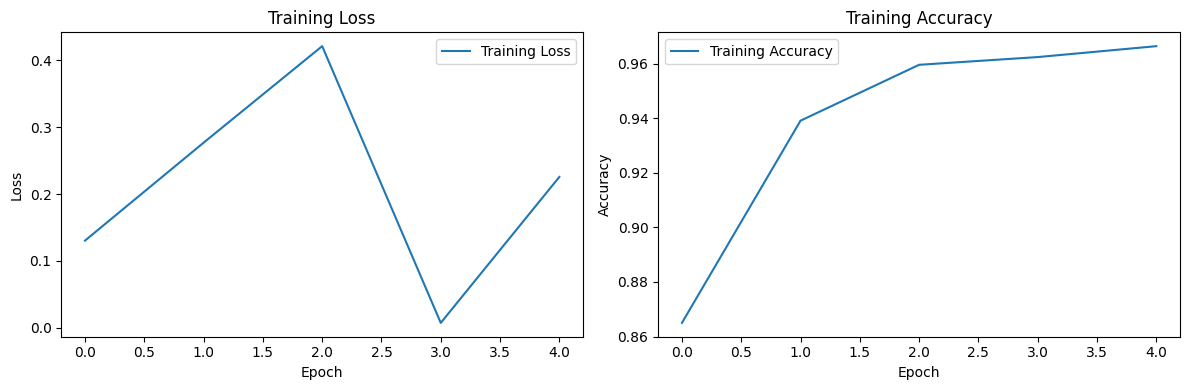

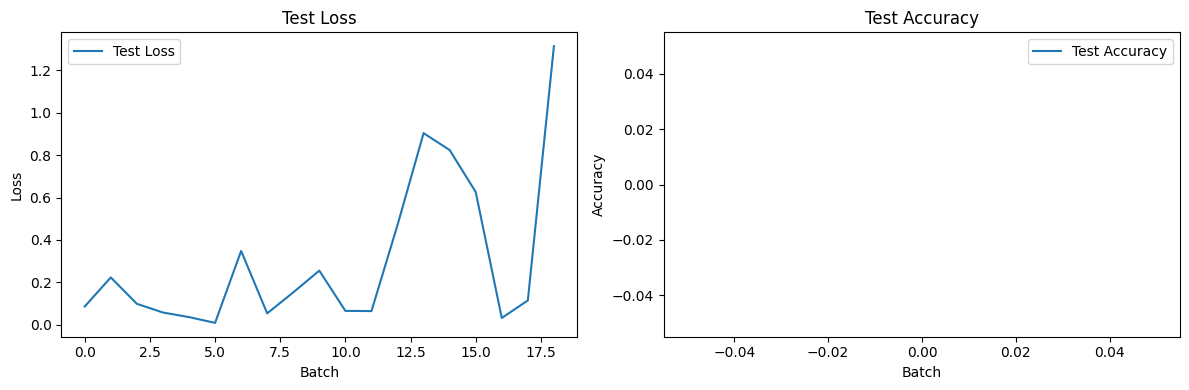

Test Accuracy: 0.915


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import torchvision.models as models
import matplotlib.pyplot as plt

# Define data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load datasets
train_dataset = datasets.ImageFolder(root="//content/MTP/dataset/equalized_images/train", transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Load pretrained ResNet model
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(train_dataset.classes))

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Training loop
num_epochs = 5
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    model.train()
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = correct / total
    train_accuracies.append(accuracy)
    train_losses.append(loss.item())

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}, Training Accuracy: {accuracy}')

# Plot the training loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot the training accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
# Load test dataset
test_dataset = datasets.ImageFolder(root="//content/MTP/dataset/equalized_images/test", transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Evaluation loop
model.eval()
test_losses = []
test_accuracies = []
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        test_losses.append(loss.item())

test_accuracy = correct / total

# Plot the test loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(test_losses, label='Test Loss')
plt.title('Test Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.legend()

# Plot the test accuracy
plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Test Accuracy')
plt.xlabel('Batch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

print(f'Test Accuracy: {test_accuracy}')





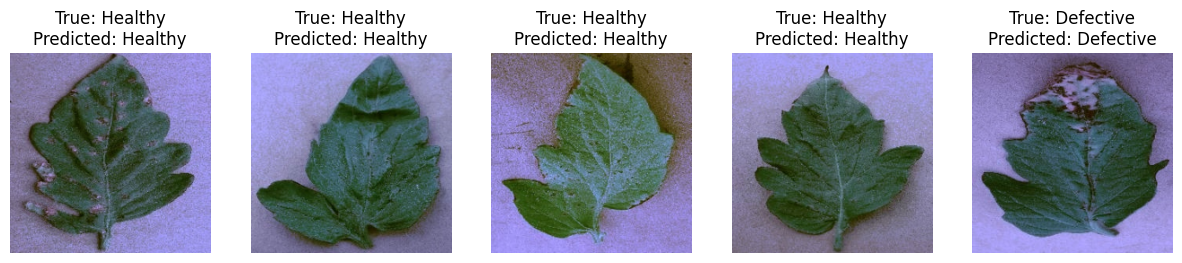

In [ ]:
import random

# Function to display random images along with their predictions
def display_random_images(model, test_loader, device, num_images=5):
    model.eval()
    images, labels = [], []

    with torch.no_grad():
        for i, (inputs, targets) in enumerate(test_loader):
            if i >= num_images:
                break

            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            images.append(inputs.cpu().numpy())
            labels.append((targets.cpu().numpy(), predicted.cpu().numpy()))

    images = np.vstack(images)
    labels = [(true, pred) for true, pred in labels]

    return images, labels

# Display 5 random images and their predictions
random_images, random_labels = display_random_images(model, test_loader, device, num_images=5)


class_labels = ["Healthy", "Defective"]
true_labels = [class_labels[int(true[0])] for true, _ in random_labels]
predicted_labels = ["Healthy" if pred[0] == 0 else "Defective" for _, pred in random_labels]

# Display the images along with their true and predicted labels
plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(np.transpose(random_images[i], (1, 2, 0)))
    plt.title(f'True: {true_labels[i]}\nPredicted: {predicted_labels[i]}')
    plt.axis('off')
plt.show()




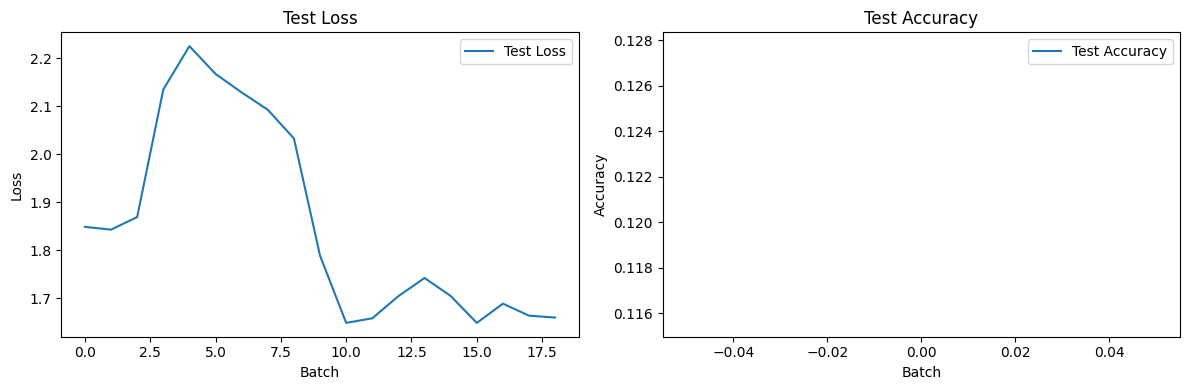

Test Accuracy: 0.12166666666666667


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import torchvision.models as models
import matplotlib.pyplot as plt

# Define data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load test dataset
test_dataset = datasets.ImageFolder(root="//content/MTP/dataset/equalized_images/test", transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load pretrained ResNet model
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(test_dataset.classes))

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Evaluation loop
model.eval()
test_losses = []
test_accuracies = []
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        test_losses.append(loss.item())

test_accuracy = correct / total

# Plot the test loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(test_losses, label='Test Loss')
plt.title('Test Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.legend()

# Plot the test accuracy
plt.subplot(1, 2, 2)
plt.plot(test_accuracy, label='Test Accuracy')
plt.title('Test Accuracy')
plt.xlabel('Batch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

print(f'Test Accuracy: {test_accuracy}')
